In [88]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
## defining functions

In [175]:
def convert_to_datetime(date_str):
  new_date = datetime.strptime(date_str[4:24],"%b %d %Y %H:%M:%S")
  return new_date

def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD 

In [203]:
#fetching_data
xl = pd.ExcelFile('/content/BANKNIFTY COMPONENT DATA.xlsx')
all_dfs = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

In [204]:
bnf = pd.read_csv('/content/Nifty Bank Historical Data.csv')
bnf

,Date,Price,Open,High,Low,Vol.,Change %
0,02/06/2024,"45,611.55","45,917.40","45,917.40","45,532.45",132.08K,-0.47%
1,02/05/2024,"45,825.55","45,962.25","46,048.60","45,615.10",265.91M,-0.32%
2,02/02/2024,"45,970.95","46,568.20","46,892.35","45,901.25",337.04M,-0.47%
3,02/01/2024,"46,188.65","46,164.90","46,306.90","45,668.35",305.72M,0.42%
4,01/31/2024,"45,996.80","45,295.65","46,179.75","45,071.20",373.13M,1.39%
...,...,...,...,...,...,...,...
2249,01/07/2015,"18,304.25","18,382.55","18,482.05","18,211.50",58.24M,-0.69%
2250,01/06/2015,"18,430.75","18,874.60","18,874.60","18,388.35",52.07M,-3.08%
2251,01/05/2015,"19,017.40","19,155.20","19,166.00","18,987.70",36.32M,-0.21%
2252,01/02/2015,"19,057.80","18,752.20","19,118.85","18,752.20",41.29M,1.64%


In [205]:
#volume['BANKNIFTY']=pd.Series(bnf['Vol.'])
vol=pd.Series()
bnf['Date'] = bnf['Date'].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))
bnf.set_index(bnf['Date'],inplace = True)

bnf = bnf.iloc[::-1]
bnf = bnf['2020-12-29':'2024-01-29']
vol=bnf['Vol.']
bnf.drop(columns = ['Date','Open','High','Low','Vol.','Change %'],inplace = True)

bnf['Price'] = bnf['Price'].apply(lambda x: float(x[0:2]+x[3:]))
bnf['daily_returns'] = bnf['Price'].pct_change(periods = 1)


bnf

<ipython-input-205-0dc4630aa908>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vol=pd.Series()


,Price,daily_returns
Date,,
2020-12-29,31322.50,NaN
2020-12-30,31303.05,-0.000621
2020-12-31,31264.05,-0.001246
2021-01-01,31225.85,-0.001222
2021-01-04,31212.45,-0.000429
...,...,...
2024-01-20,46108.50,0.008913
2024-01-23,45015.05,-0.023715
2024-01-24,45082.40,0.001496


In [206]:
all_dfs_copy = all_dfs
volume=pd.DataFrame(columns=list(all_dfs_copy.keys())+['BANKNIFTY'])

start_date = datetime(2018,3,27)
end_date = datetime(2024,1,29)

for key in all_dfs_copy.keys():

  all_dfs_copy[key]['Date'] = all_dfs_copy[key]['Date'].apply(convert_to_datetime)
  all_dfs_copy[key].set_index(all_dfs_copy[key]['Date'],inplace = True)
  all_dfs_copy[key].drop(columns = ['Date'],inplace = True)
  all_dfs_copy[key] = all_dfs_copy[key]['2020-12-29':'2024-01-29']
  all_dfs_copy[key]['daily_returns'] = all_dfs_copy[key]['Close'].pct_change(periods = 1)
  volume[key]= all_dfs_copy[key]['Volume']

  all_dfs_copy[key].drop(columns = ['Open','High','Low','Volume'],inplace = True)

all_dfs_copy['AUBANK'].drop(columns = ['Exchange','Segment'],inplace = True)
all_dfs_copy['AXISBANK'].dropna(axis = 1,how = 'all',inplace = True)


In [207]:
dfs_is = dict()
dfs_os = dict()
for key in all_dfs_copy.keys():
  dfs_is[key] = all_dfs_copy[key]['2020-12-29':'2024-01-29']
  #dfs_os[key] = all_dfs_copy[key]['2023-01-01':'2024-01-29']


In [208]:
df = pd.DataFrame(index = dfs_is['AUBANK'].index,columns=list(dfs_is.keys())+['BANKNIFTY'])
for key in all_dfs_copy.keys():
  df[key] = all_dfs_copy[key]['daily_returns']
df['BANKNIFTY'] = bnf['daily_returns']['2020-12-29':'2024-01-29']
df.dropna(axis = 0,inplace = True)


In [209]:
df

,AUBANK,AXISBANK,BANDHANBNK,BANKBARODA,FEDERALBNK,HDFCBANK,ICICIBANK,IDFCFIRSTB,INDUSINDBK,KOTAKBANK,PNB,SBIN,BANKNIFTY
Date,,,,,,,,,,,,,
2020-12-30,0.004714,-0.008093,-0.017183,-0.004010,-0.002226,0.003714,-0.000095,-0.001362,-0.015171,0.009328,-0.013554,-0.003598,-0.000621
2020-12-31,0.000117,-0.007439,-0.009480,-0.010467,-0.008178,0.002653,0.011915,0.010914,-0.004560,-0.011076,0.009160,-0.007042,-0.001246
2021-01-01,0.026624,0.005399,-0.005096,0.049634,0.020240,-0.007833,-0.014111,0.009447,0.005810,-0.000777,0.052950,0.016185,-0.001222
2021-01-04,0.009025,0.001443,-0.007996,0.020155,0.036738,-0.006351,0.007962,0.032086,-0.002555,-0.014293,0.021552,0.005906,-0.000429
2021-01-05,0.001698,0.063631,0.012217,-0.003040,0.024805,0.007556,0.010438,0.028497,0.026508,-0.002951,0.001406,0.002491,0.016333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-20,0.023202,0.003985,0.015252,0.008021,-0.006824,0.005576,0.009508,0.023337,-0.016495,0.024089,0.027397,0.005814,0.008913
2024-01-23,-0.041472,-0.028323,-0.025909,-0.043441,-0.036414,-0.034824,0.020174,-0.067275,-0.060996,-0.012342,-0.059524,-0.041653,-0.023715
2024-01-24,0.028960,-0.027634,0.003129,0.028103,0.013904,0.020002,-0.029007,-0.026895,0.034092,0.002298,0.034937,0.021815,0.001496


In [193]:
volume

,AUBANK,AXISBANK,BANDHANBNK,BANKBARODA,FEDERALBNK,HDFCBANK,ICICIBANK,IDFCFIRSTB,INDUSINDBK,KOTAKBANK,PNB,SBIN,BANKNIFTY
Date,,,,,,,,,,,,,
2020-12-29,2171508,13765454,8237480,41508873,29998634,7247673,19092649,18963239,20727636,3152865,160162623,45032526,NaN
2020-12-30,1182792,10262221,6415631,33108560,19496396,8108363,21365141,19633682,11462263,2657431,92597922,30971894,NaN
2020-12-31,1303682,12306502,11457749,22488846,17910330,11072875,27817770,25499169,6435333,2794829,189388220,29467966,NaN
2021-01-01,1512142,6047062,5230681,43369915,14471914,4405469,13592625,12858049,4632855,1106099,227528491,24531791,NaN
2021-01-04,2693724,14068156,9725066,40279407,45809327,7870096,16549750,48722834,6991890,3141429,213599078,31450608,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-20,1930061,5055594,10792549,10482470,8929988,12920293,8788873,27900269,3158588,5456020,51901229,9886760,NaN
2024-01-23,3081087,18924087,12418558,36926359,15830801,57734701,50797448,95355822,10097057,6780824,83723415,30954343,NaN
2024-01-24,2550245,20884046,11443782,36236660,18178107,43002202,34578943,85088545,9155544,3268351,65088374,19221835,NaN


In [210]:
volume['BANKNIFTY']= vol
volume=volume.iloc[1:]
volume.set_index(df.index)

,AUBANK,AXISBANK,BANDHANBNK,BANKBARODA,FEDERALBNK,HDFCBANK,ICICIBANK,IDFCFIRSTB,INDUSINDBK,KOTAKBANK,PNB,SBIN,BANKNIFTY
Date,,,,,,,,,,,,,
2020-12-30,1182792,10262221,6415631,33108560,19496396,8108363,21365141,19633682,11462263,2657431,92597922,30971894,267.80M
2020-12-31,1303682,12306502,11457749,22488846,17910330,11072875,27817770,25499169,6435333,2794829,189388220,29467966,364.12M
2021-01-01,1512142,6047062,5230681,43369915,14471914,4405469,13592625,12858049,4632855,1106099,227528491,24531791,362.82M
2021-01-04,2693724,14068156,9725066,40279407,45809327,7870096,16549750,48722834,6991890,3141429,213599078,31450608,455.78M
2021-01-05,1533304,37973963,11743029,31735002,41838390,7193412,23311516,54314659,11907501,3263230,142225084,27393072,427.04M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-20,1930061,5055594,10792549,10482470,8929988,12920293,8788873,27900269,3158588,5456020,51901229,9886760,NaN
2024-01-23,3081087,18924087,12418558,36926359,15830801,57734701,50797448,95355822,10097057,6780824,83723415,30954343,422.62M
2024-01-24,2550245,20884046,11443782,36236660,18178107,43002202,34578943,85088545,9155544,3268351,65088374,19221835,348.70M


In [149]:
ret_n=pd.DataFrame()
for stock in df.columns:
  ret_n[stock] = (df[stock] - df[stock].mean())/df[stock].std()
df

,AUBANK,AXISBANK,BANDHANBNK,BANKBARODA,FEDERALBNK,HDFCBANK,ICICIBANK,IDFCFIRSTB,INDUSINDBK,KOTAKBANK,PNB,SBIN,BANKNIFTY
Date,,,,,,,,,,,,,
2020-12-30,0.004714,-0.008093,-0.017183,-0.004010,-0.002226,0.003714,-0.000095,-0.001362,-0.015171,0.009328,-0.013554,-0.003598,-0.000621
2020-12-31,0.000117,-0.007439,-0.009480,-0.010467,-0.008178,0.002653,0.011915,0.010914,-0.004560,-0.011076,0.009160,-0.007042,-0.001246
2021-01-01,0.026624,0.005399,-0.005096,0.049634,0.020240,-0.007833,-0.014111,0.009447,0.005810,-0.000777,0.052950,0.016185,-0.001222
2021-01-04,0.009025,0.001443,-0.007996,0.020155,0.036738,-0.006351,0.007962,0.032086,-0.002555,-0.014293,0.021552,0.005906,-0.000429
2021-01-05,0.001698,0.063631,0.012217,-0.003040,0.024805,0.007556,0.010438,0.028497,0.026508,-0.002951,0.001406,0.002491,0.016333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-20,0.023202,0.003985,0.015252,0.008021,-0.006824,0.005576,0.009508,0.023337,-0.016495,0.024089,0.027397,0.005814,0.008913
2024-01-23,-0.041472,-0.028323,-0.025909,-0.043441,-0.036414,-0.034824,0.020174,-0.067275,-0.060996,-0.012342,-0.059524,-0.041653,-0.023715
2024-01-24,0.028960,-0.027634,0.003129,0.028103,0.013904,0.020002,-0.029007,-0.026895,0.034092,0.002298,0.034937,0.021815,0.001496


In [ ]:
##Correlation matrix calculation 

<Axes: >

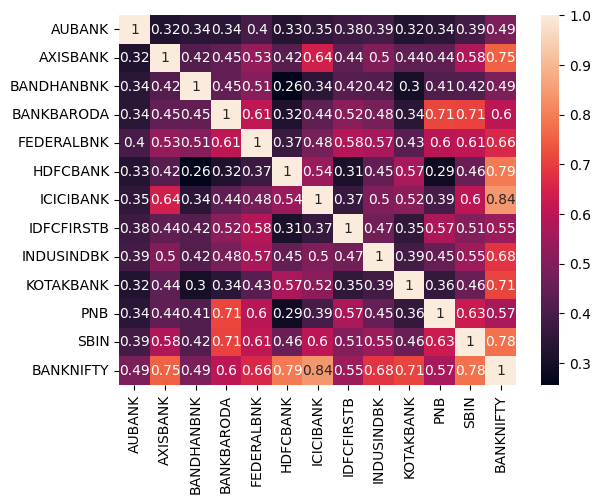

In [150]:
stocks = ret_n.columns.drop(['BANKNIFTY'])
corr_matrix = ret_n.corr()
sns.heatmap(corr_matrix,color = "red",annot=True)

In [ ]:
#eigenvalue calculation 

In [151]:
eigen_val,eigen_vec = np.linalg.eig(ret_n[stocks].corr())
eigen_val = list(eigen_val)

In [152]:
np.sort(eigen_val)[::-1]

array([6.02426216, 1.18827704, 0.7882365 , 0.68289612, 0.60690358,
       0.55254443, 0.51991305, 0.41326708, 0.35409422, 0.33249977,
       0.29959618, 0.23750985])

(0.0, 0.7)

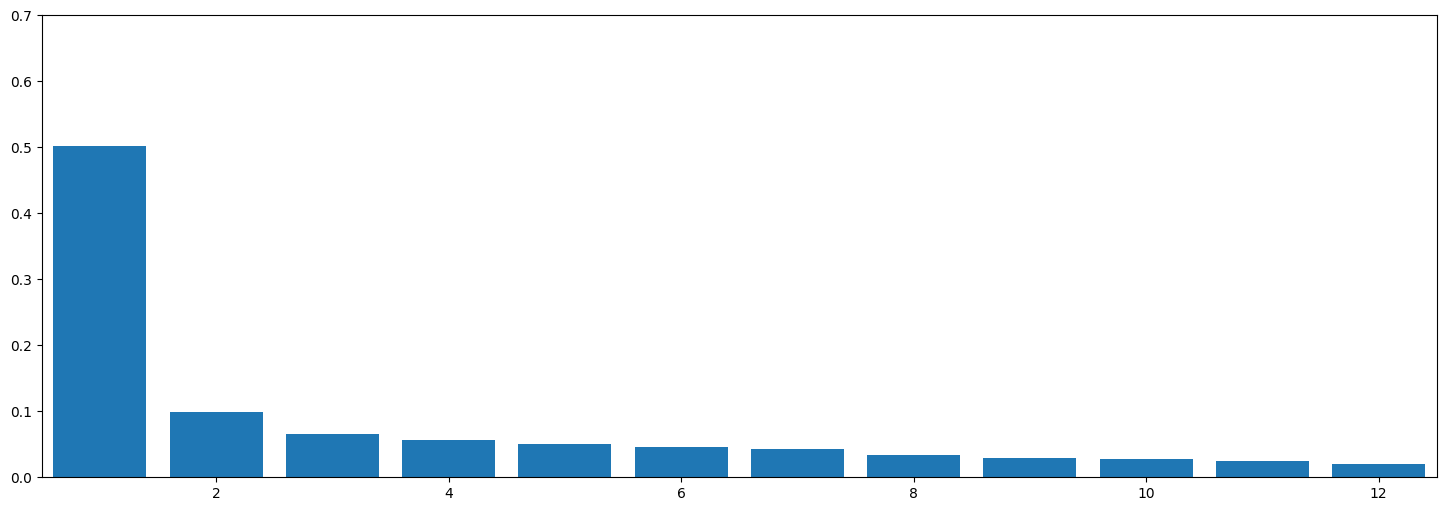

In [153]:
plt.figure(figsize=(18,6))
plt.bar(np.arange(1,13),height = (np.sort(eigen_val)[::-1])/sum(eigen_val))
plt.xlim(0.5,12.5)
plt.ylim(0,0.7)

In [ ]:
#weight calculation through maximum eigenvalue 

In [154]:
weights = eigen_vec[:,eigen_val.index(max(eigen_val))]/df[stocks].std()
weights = weights/weights.sum()

In [ ]:
#cumulative daily returns (Daily buy and sell) 

In [155]:
ret_eig = np.cumprod((weights*df[stocks]).sum(axis=1)+1)
ret_index = np.cumprod(df.loc[:,'BANKNIFTY']+1)

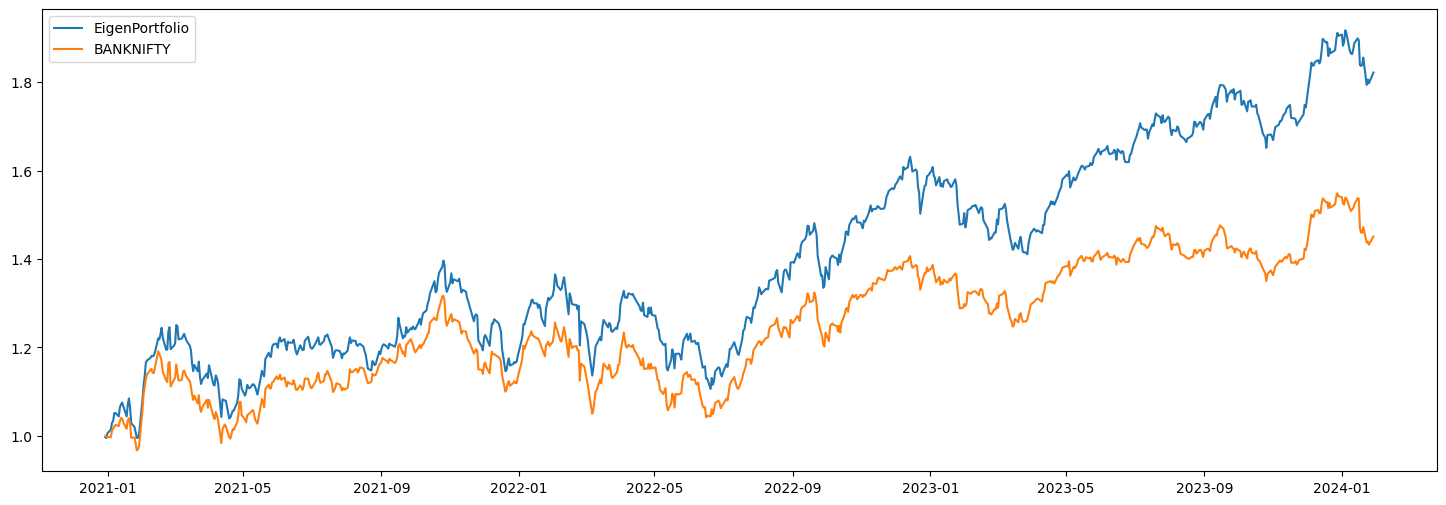

In [156]:
plt.figure(figsize=(18,6))
plt.plot(ret_eig,label='EigenPortfolio')
plt.plot(ret_index,label = 'BANKNIFTY')
plt.legend()

In [157]:
#fraction of variance explained by top n PCs
def percentage_of_variance(returns,window,n):
  explained_variance = []
  for t,dt in enumerate(returns.iloc[window-1:].index):
    tmp_ret = returns.loc[:dt]
    tmp_ret = tmp_ret.iloc[-window:]
    evals = np.linalg.eig(tmp_ret.corr())[0]
    evals = np.sort(evals)[::-1]
    explained_variance.append(evals[:n].sum()/evals.sum())
  plt.figure(figsize=(18,6))
  plt.plot(explained_variance,label = 'Fraction of variance explained by 1st PC')
  plt.legend()

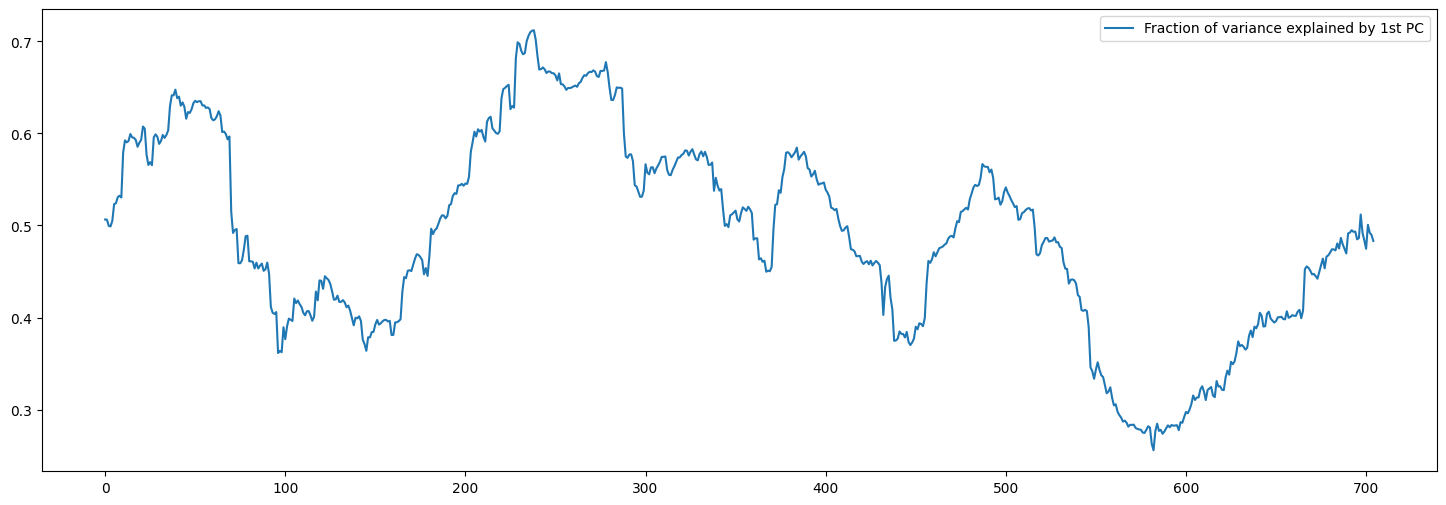

In [158]:
#fraction of variance explained by 1st PC
percentage_of_variance(df[stocks],60,1)

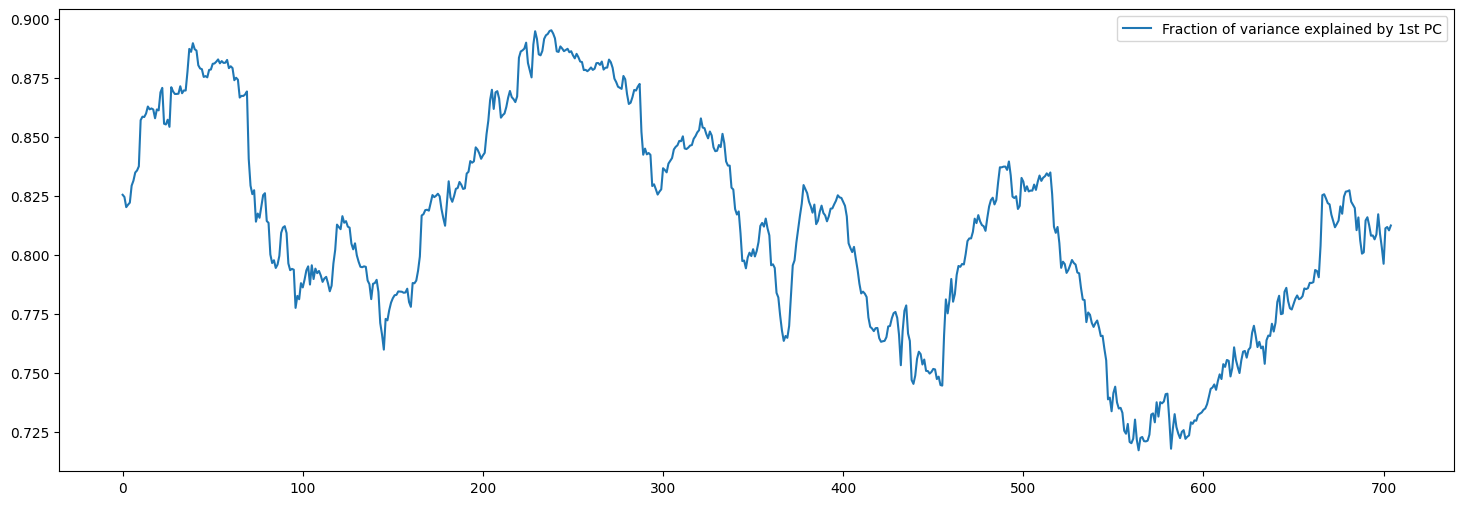

In [159]:
#fraction_of_variance explained by top 5 PCs
percentage_of_variance(df[stocks],60,5)

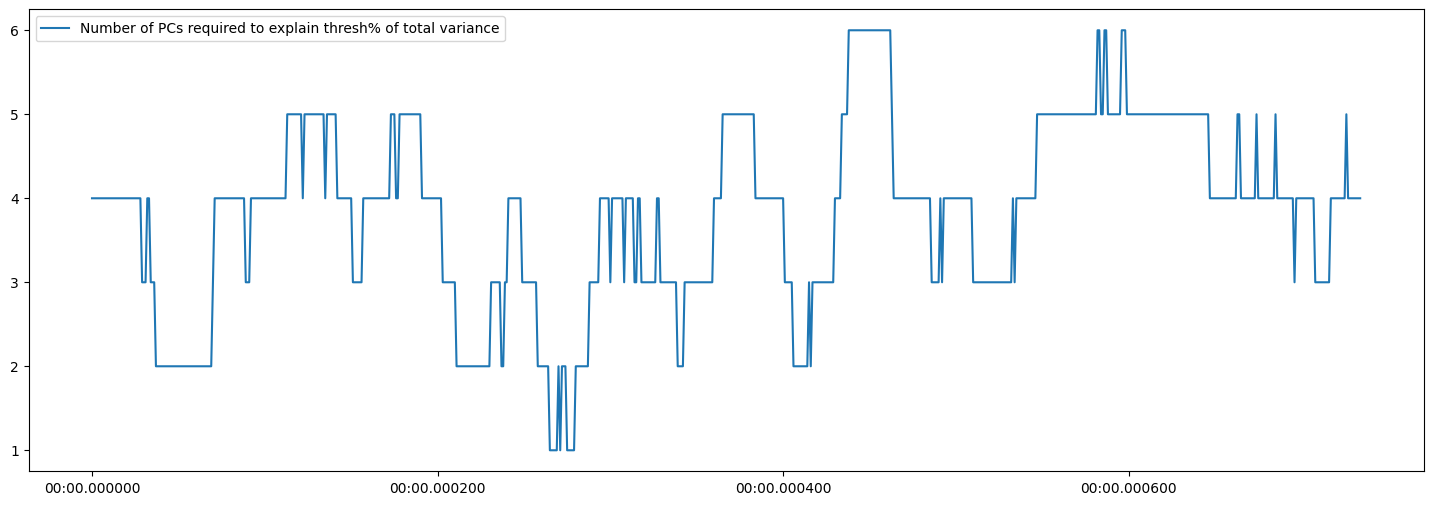

In [160]:
#number of components required to explain at least n% of total variance
window = 30
thresh = 0.75
num_components = pd.DataFrame(index = df.index,columns = ['n_comp'])
for t,dt in enumerate(df.iloc[window-1:].index):
  tmp_ret = df[stocks].loc[:dt]
  tmp_ret = tmp_ret.iloc[-window:]
  evals = np.linalg.eig(tmp_ret.corr())[0]
  evals = np.sort(evals)[::-1]
  explained_variance = evals/np.sum(evals)
  n_comp = np.where((np.cumsum(explained_variance))>=thresh)[0][0]+1
  num_components.loc[t] = n_comp
plt.figure(figsize = (18,6))
plt.plot(num_components,label = 'Number of PCs required to explain thresh% of total variance')
plt.legend()


In [1]:
#Correlation matrix of eigen

In [231]:
df[['eig1','eig2','eig3','eig4','eig5','eig6']] = np.nan
for t in df.iloc[29:].index:
  tmp_ret = df[stocks].loc[:t]
  tmp_ret = tmp_ret.iloc[-30:]
  evals,evecs = np.linalg.eig(tmp_ret.corr())
  index = np.argsort(evals)[::-1]
  for i in range(1,7):
    weights = evecs[:,index[i-1]]/tmp_ret.std()
    weights /= abs(weights).sum()
    df.loc[t][f'eig{i}'] = (weights*tmp_ret.iloc[-1]).sum()

In [232]:
df[['eig1','eig2','eig3','eig4','eig5','eig6']].corr()

,eig1,eig2,eig3,eig4,eig5,eig6
eig1,1.000000,-0.059588,0.023747,0.033321,-0.003282,-0.005480
eig2,-0.059588,1.000000,0.000159,0.047466,0.019890,-0.051396
eig3,0.023747,0.000159,1.000000,0.142204,0.062503,-0.008637
eig4,0.033321,0.047466,0.142204,1.000000,0.077964,-0.052664
eig5,-0.003282,0.019890,0.062503,0.077964,1.000000,-0.056996
eig6,-0.005480,-0.051396,-0.008637,-0.052664,-0.056996,1.000000


In [233]:
df[['eig1']]

,eig1
Date,
2020-12-30,NaN
2020-12-31,NaN
2021-01-01,NaN
2021-01-04,NaN
2021-01-05,NaN
...,...
2024-01-20,0.009575
2024-01-23,0.035450
2024-01-24,0.009377


In [234]:
#implementing PCA portfolio
def n_pca_portfolio(modified_returns,returns,num_pc,l_win,s_win):
  stocks =  list(returns.columns.drop(['BANKNIFTY','eig1','eig2','eig3','eig4','eig5','eig6']))
  s_scores = pd.DataFrame(index = returns.iloc[l_win:].index,columns = stocks)
  betas = pd.DataFrame(index = returns.iloc[l_win:].index,columns = stocks)
  pcs = ['eig1','eig2','eig3','eig4','eig5','eig6']
  none_list = []
  for t in modified_returns.index[l_win:]:
    tmp_ret = modified_returns.loc[:t]
    tmp_ret = tmp_ret.iloc[-s_win:]
    tmp_ret = (tmp_ret - tmp_ret.mean())/tmp_ret.std()
    ou_params = pd.DataFrame(index=stocks,columns = ['a','b','Var(zeta)','kappa','m',
                                                     'sigma','sigma_eq'])
    for stock in stocks:
      X = tmp_ret[pcs[:num_pc]].values
      y = tmp_ret[stock].values
      model1 = LinearRegression().fit(X,y)
      betas.loc[t,stock] = model1.coef_
      epsilon = y - model1.predict(X)

      #second regression
      Xk = epsilon.cumsum()
      X = Xk[:-1].reshape(-1,1)
      y = Xk[1:]
      model2 = LinearRegression().fit(X,y)
      a = model2.intercept_
      b = model2.coef_
      zeta = y - model2.predict(X)

      #OU parameters
      kappa = -np.log(b)*252
      m = a/(1-b)
      sigma = np.sqrt(np.var(zeta)*2*kappa/(1-b**2))
      sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))

      #if the speed of mean reversion is high enough, save the calulated parameters
      if kappa>(252/30):
          ou_params.loc[stock] = [x.item() for x in [a,b,np.var(zeta),kappa,m,sigma,sigma_eq]]

    #ou_params.dropna(axis=0,inplace = True)
    ou_params['m_bar'] = (ou_params['a']/(1-ou_params['b']) - ou_params['a'].mean()/(1-ou_params['b'].mean()))
    ou_params['s'] = -ou_params['m_bar']/ou_params['sigma_eq']
    s_scores.loc[t] = ou_params['s']

  null_indices = s_scores.isnull().any(axis = 1)
  null_indices = null_indices[null_indices == True]
  s_scores.dropna(axis = 0,inplace = True)
  betas.drop(index=null_indices.index,inplace = True)
  #no holding condition given
  #calculate positions
  algo_pos = pd.DataFrame(index = s_scores.index[1:],columns=stocks)
  for s in stocks:
    positions = pd.DataFrame(index=s_scores.index,columns=[s])
    pos = 0
    for t in s_scores.index:
      score = s_scores.loc[t][s]

      if score>1.25:
        positions.loc[t][s] = -1 #open short
        pos = -1
      if score<-1.25:
        positions.loc[t][s] = 1#open long
        pos = 1
      elif score<0.5 and pos==-1:
        positions.loc[t][s] = 0 #close short
        pos = 0
      elif score>-0.5 and pos==1:
        positions.loc[t][s] = 0 #close long
        pos = 0
      else:
        positions.loc[t][s] = pos #carry forward current position




      '''

      if score>1.25 and pos!=-1:
        positions.loc[t][s] = -1 #open short
        pos = -1
      elif score<-1.25 and pos != 1:
        positions.loc[t][s] = 1#open long
        pos = 1
      elif score<0.75 and pos==-1:
        positions.loc[t][s] = 0 #close short
        pos = 0
      elif score>-0.5 and pos==1:
        positions.loc[t][s] = 0 #close long
        pos = 0
      else:
        positions.loc[t][s] = pos #carry forward current position
      '''
    algo_pos[s] = positions
  #calculate weights(allocate equal amount of capital to long/short positions)
  algo_weights = pd.DataFrame(index = algo_pos.index,columns = stocks)
  for t in algo_pos.index:
    tmp = algo_pos.loc[t]
    tmp[tmp>0] /= sum(tmp>0) #equal weights among long positions
    tmp[tmp<0] /= sum(tmp<0) #equal weights among short positions
    algo_weights.loc[t] = tmp

  #calculate positions in PCA portfolios
  algo_weights[pcs[:num_pc]] = (-np.stack((betas.iloc[1:,:]*algo_weights).sum(axis=1).values)).reshape(-1,1)

  # calculate returns
  ret = (returns.iloc[l_win+1:] * algo_weights.shift().bfill()).sum(axis=1) / (abs(algo_weights.shift().bfill()).sum(axis=1)/2)
  cumret = np.nancumprod(ret+1)

  # calculate returns of BANKNIFTY for comparison
  bbh_cumret = np.nancumprod(returns.loc[ret.index]['BANKNIFTY']+1)
  plt.figure(figsize=(18,6))
  plt.grid(True)
  plt.plot(ret.index,cumret, label='Algo')
  plt.plot(ret.index,bbh_cumret, label='BANKNIFTY')
  plt.legend()
  return cumret, s_scores

<ipython-input-234-9446ecb5bbb9>:31: RuntimeWarning: invalid value encountered in log
  kappa = -np.log(b)*252
<ipython-input-234-9446ecb5bbb9>:34: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.var(zeta)/(1-b**2))


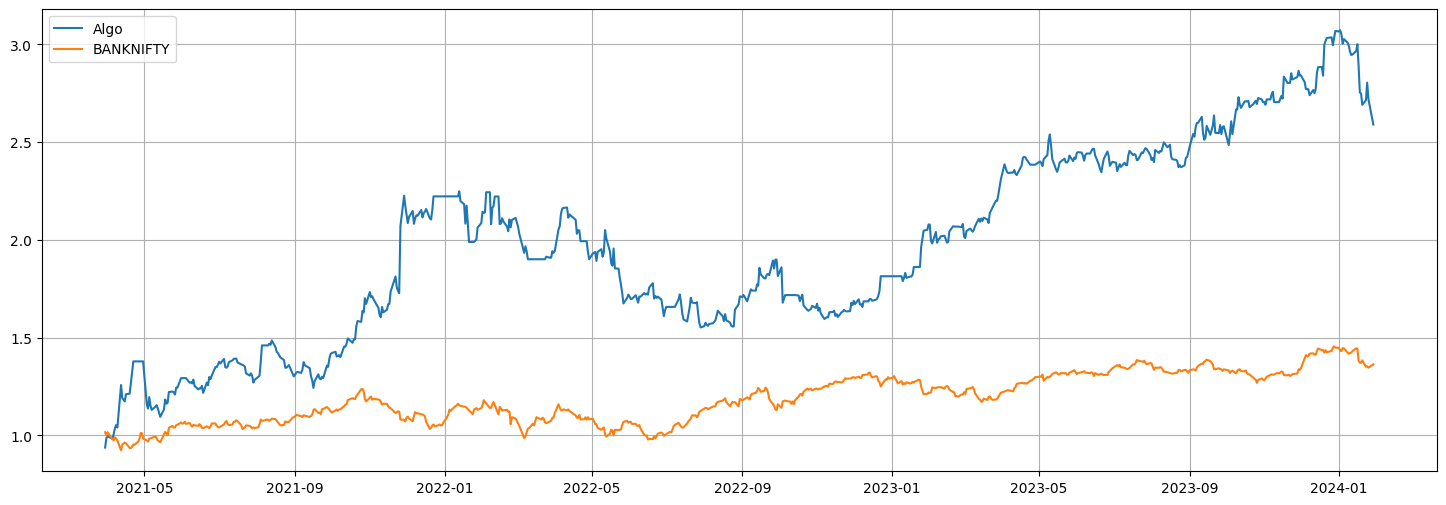

In [237]:
cumret, s_scores = n_pca_portfolio(df,df,1,60,30)

In [238]:
def calculate_metrics(cumret):

    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD

In [239]:
total_return, apr, sharpe, maxDD, maxDDD= calculate_metrics(cumret)

In [240]:
print(total_return, apr, sharpe, maxDD, maxDDD)

1.76200505357593 0.43933858375295 1.1920214875923745 -0.3096964137750291 300.0
